In [20]:
import os
import pandas as pd

import mar
import preprocessing

In [21]:
pat_num = 4

In [22]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

In [23]:
mar_data = preprocessing.load_mar_data(data_dir, pat_num)
sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
accel_data = preprocessing.load_accel_data(data_dir, pat_num)
# ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

In [24]:
mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

for mar_class in mar_classes:
    print(mar_class + " : " + str(mar_classes[mar_class].shape))

narcotics : (265, 4)
paralytics : (0, 4)
alpha_agonists : (506, 4)
ketamines : (12, 4)
propofols : (0, 4)
etomidates : (0, 4)
benzodiazepines : (0, 4)


In [25]:
drug_doses = {}
drug_concentrations = {}

for mar_class in mar_classes:
    if mar_classes[mar_class].shape[0] < 1:
        continue

    for drug_name in mar.classes()[mar_class]:
        drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
        
        if drug_df.shape[0] < 1:
            continue

        print(drug_name + " : " + str(drug_df.shape))

        drug_doses[drug_name] = mar.calculate_doses(drug_df)
        drug_concentrations[drug_name] = mar.calculate_concentrations_rk4(drug_doses[drug_name], elimination_rate=mar.elimination_rates()[drug_name])

print("")

for drug_name in drug_doses:
    print(drug_name + " : " + str(drug_doses[drug_name].shape))

fentanyl : (265, 4)
dexmedetomidine : (467, 4)
clonidine : (39, 4)
ketamine : (12, 4)

fentanyl : (21316, 4)
dexmedetomidine : (34222, 4)
clonidine : (25489, 4)
ketamine : (28777, 4)


In [ ]:
for drug_name in drug_concentrations:
    mar.plot_concentration(drug_concentrations, drug_name, show=False, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug_name}_concentration.png'))

mar.plot_concentration(drug_concentrations, 'all', show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_all_concentration.png'))

In [ ]:
metrics = {
    'heart_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'heart_rate': sickbay_data['heart_rate']
    }),
    'respiratory_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'respiratory_rate': sickbay_data['respiratory_rate']
    }),
    'acceleration': pd.DataFrame({
        'time': accel_data['time'],
        'acceleration': accel_data['a']
    }),
}

In [ ]:
windows = [2, 60, 3600]

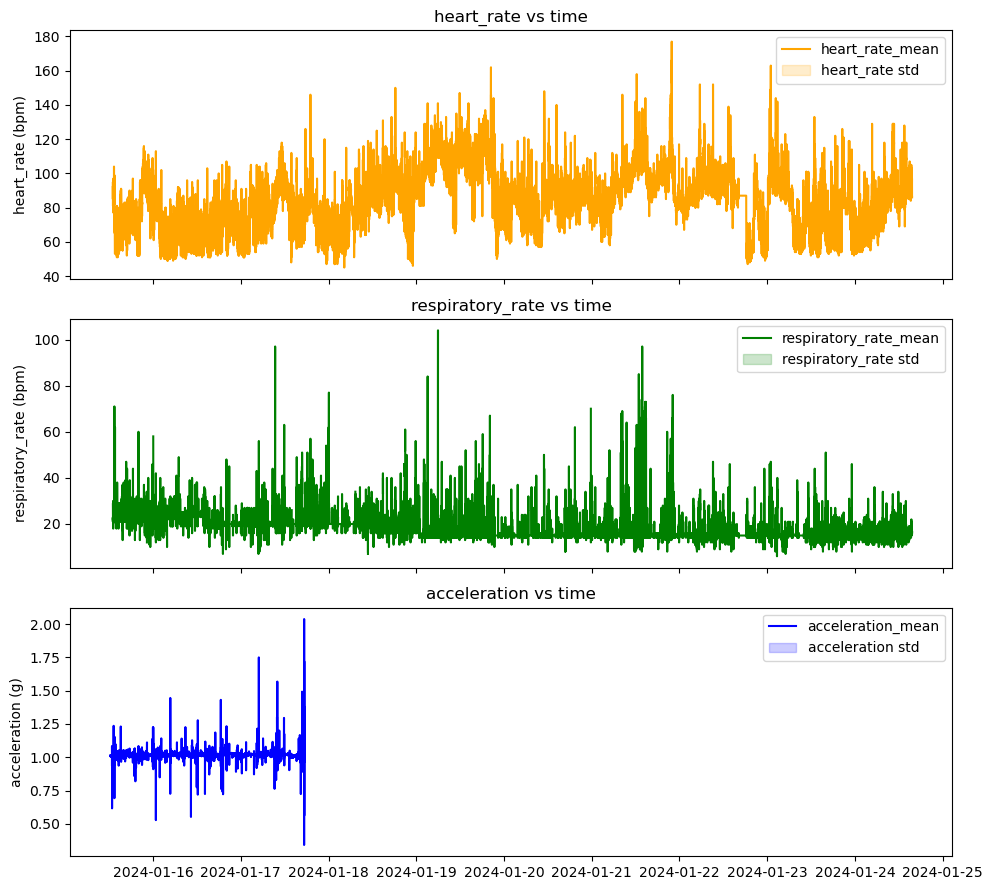

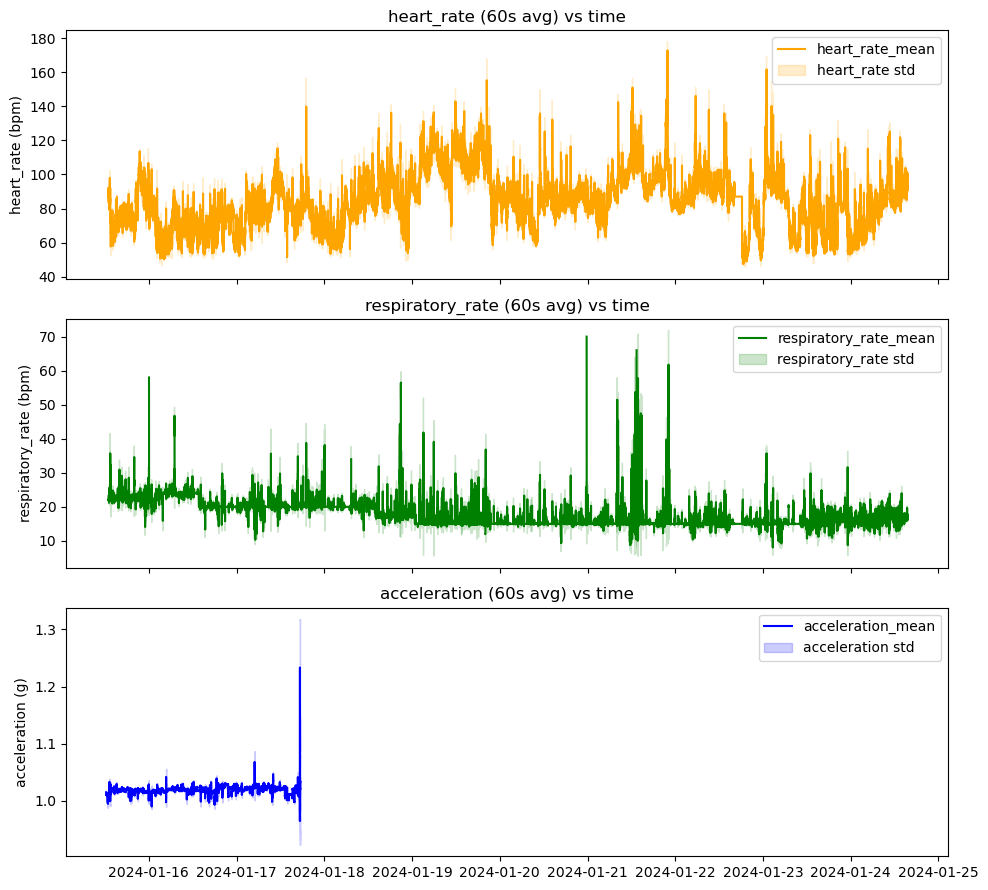

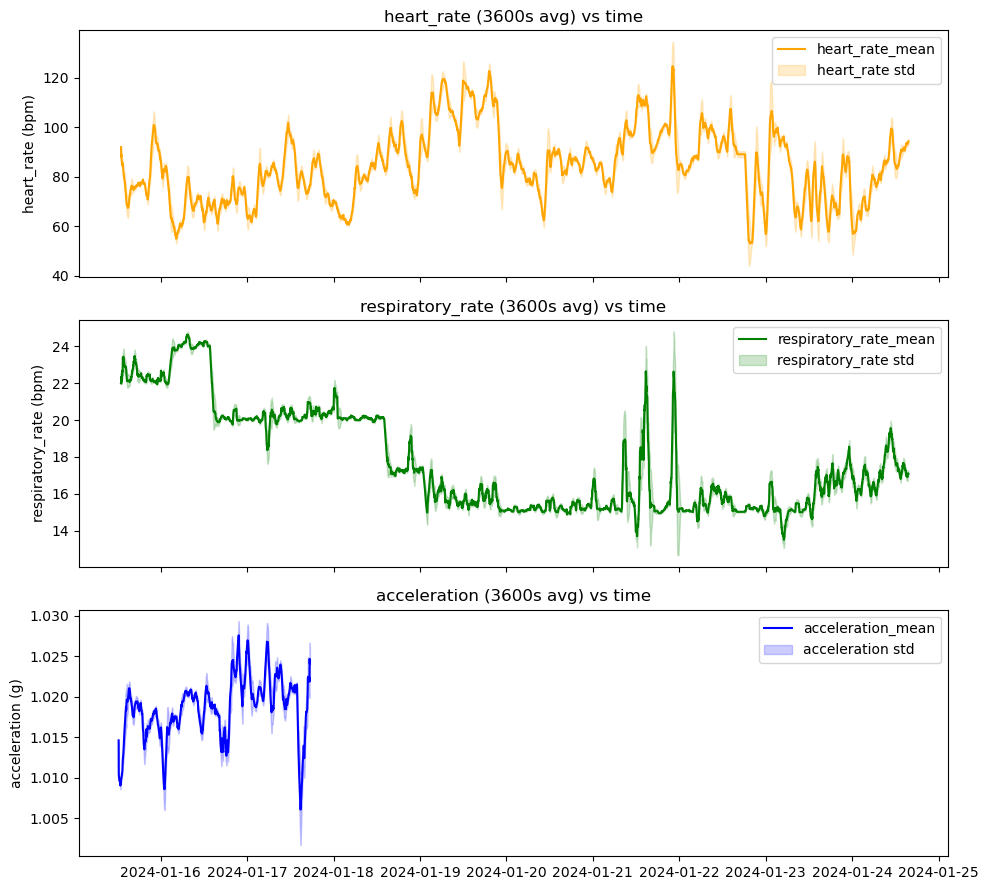

In [ ]:
for window in windows:
    mar.plot_metrics(metrics, window=window, std=True, show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_metrics_{window}s.png'))

In [ ]:
start = max([df['time'].min() for df in metrics.values()])
stop = min([df['time'].max() for df in metrics.values()])

print(start)
print(stop)

2024-01-15 13:00:00
2024-01-17 17:26:48


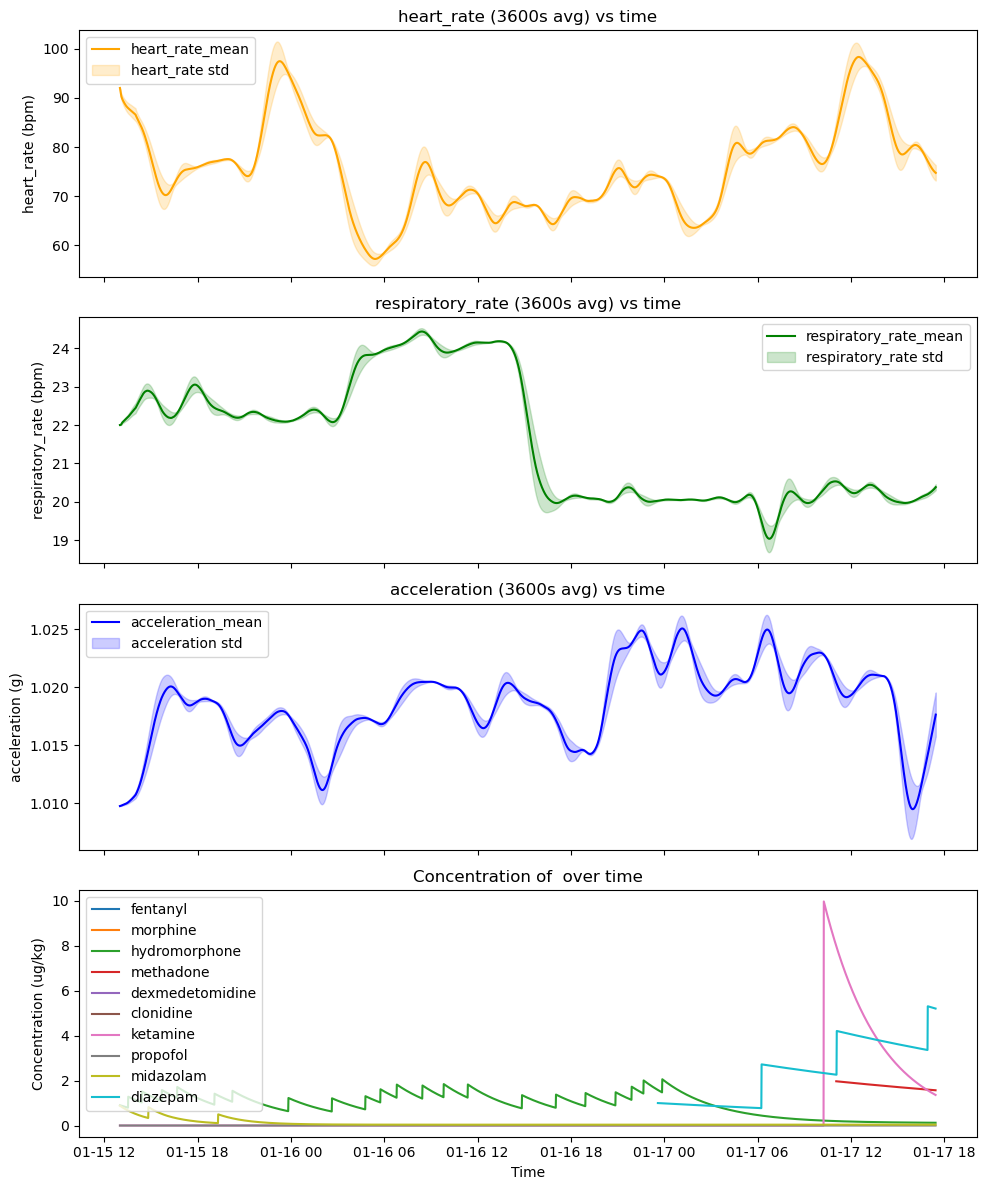

In [ ]:
mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name='all', window=3600, std=True, start=start, stop=stop, show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_metrics_and_concentrations_{3600}s.png'))